#  **GOAL: Develop Question and Answer system that understands context**
---
End to End memory Model using bAbI dataset <br>
by Shaimaa Kouka&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;&nbsp;Data Science Bootcamp 2021<br>
 

---





### - *The file format for each task is as follows:*

ID text
ID text
ID text
ID question[tab]answer[tab]supporting fact IDS.<br>
The IDs for a given **"story"** at 1 and increase. When the IDs in a file reset back to 1 you can consider the following sentences as a new **“story”**. Supporting fact IDs only ever reference the sentences within a **“story”**.<br>

For Example:<br>

1 Mary moved to the bathroom.<br>
2 John went to the hallway.<br>
3 Where is Mary? &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; bathroom&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1<br>
4 Daniel went back to the hallway.<br>
5 Sandra moved to the garden.<br>
6 Where is Daniel?&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;hallway&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4<br>
1 Sandra travelled to the office.<br>
2 Sandra went to the bathroom.<br>
3 Where is Sandra?&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;bathroom&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2<br>

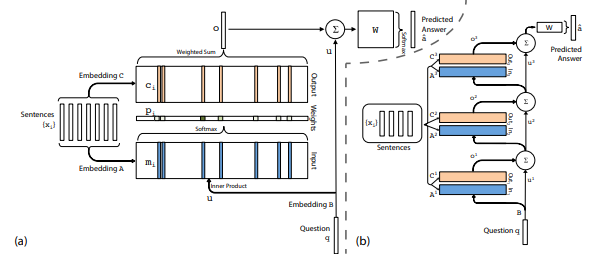

# Step 1 :  Import Libraries

- tarfile to **unzip the file**
- Pandas and nltk,functool , and numpy is for **data cleaning and manipulation**
- keras and tensorflow for **building the Neural Network model**
- matplotlib for **visualizing the results**

In [ ]:
#import libraries
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Activation, Dense, Dropout, Permute
from keras.layers.embeddings import Embedding
from keras.layers.merge import add, concatenate, dot
from keras.layers.recurrent import LSTM
from keras.models import Model, Sequential
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import np_utils
from keras.utils.data_utils import get_file


import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import tarfile
from functools import reduce

%matplotlib inline
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Step 2 : Import Data
Download then extract the bAbI files using shell commands

In [ ]:
#import the file
!curl -O https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz
!tar -xf babi_tasks_1-20_v1-2.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.2M  100 11.2M    0     0  11.3M      0 --:--:-- --:--:-- --:--:-- 11.3M


In [ ]:
path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
tar = tarfile.open(path)

11747328/11745123 [==============================] - 1s 0us/step


# Step 3 : Explore data

In [ ]:
pd.read_csv('tasks_1-20_v1-2/en-10k/qa6_yes-no-questions_train.txt',header=None)

,0
0,1 Mary moved to the bathroom.
1,2 Sandra journeyed to the bedroom.
2,3 Is Sandra in the hallway? \tno\t2
3,4 Mary went back to the bedroom.
4,5 Daniel went back to the hallway.
...,...
30607,11 Sandra got the milk there.
30608,12 Is Mary in the kitchen? \tno\t8
30609,13 Sandra travelled to the bedroom.
30610,14 Sandra took the apple there.


# Step 4 : Read the files & Re-format the data 
- Break the sequence of sentences to list of tuples 
- format is  [&nbsp;&nbsp;&nbsp;(&nbsp;&nbsp;&nbsp;[&nbsp;&nbsp;&nbsp;"substory1",&nbsp;&nbsp;&nbsp; "substory2",&nbsp;&nbsp;&nbsp; ,,,,&nbsp;&nbsp;&nbsp;],&nbsp;&nbsp;&nbsp; ["question"],&nbsp;&nbsp;&nbsp; "answer"&nbsp;&nbsp;&nbsp;),&nbsp;&nbsp;&nbsp;.....&nbsp;&nbsp;&nbsp;]
- Size of training set is 10k and testing is 1k

In [ ]:
def tokenize(sent):
    return word_tokenize(sent)
 
def parse_stories(lines):
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            # reset story when line ID=1 (start of new story)
            story = []
        if '\t' in line:
            # this line is tab separated Q, A &amp;amp;amp;amp;amp; support fact ID
            q, a, supporting = line.split('\t')
            # tokenize the words of question
            q = tokenize(q)
            # Provide all the sub-stories till this question
            substory = [x for x in story if x]
            # A story ends and is appended to global story data-set
            data.append((substory, q, a))
            story.append('')
        else:
            # this line is a sentence of story
            sent = tokenize(line)   
            story.append(sent)
    return data
 
def get_stories(f):#returns list of all stories in the argument data-set file
    
    # read the data file and parse 10k stories
    data = parse_stories(f.readlines())
    # lambda func to flatten the list of sentences into one list
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    # creating list of tuples for each story
    data = [(flatten(story), q, answer) for story, q, answer in data]
    return data

In [ ]:
#read the data and parse it
filename = 'tasks_1-20_v1-2/en-10k/qa6_yes-no-questions_{}.txt'
# Extracting train stories
train_data = get_stories(tar.extractfile(filename.format('train')))
# Extracting test stories
test_data = get_stories(tar.extractfile(filename.format('test')))

In [ ]:
print('Number of training stories:', len(train_data))
print('Number of test stories:', len(test_data))

Number of training stories: 10000
Number of test stories: 1000


# Step 5 : Create Vocabulary

In [ ]:
#First we will build a set of all the words in the dataset:
vocab = set()
for story, question, answer in train_data:
    vocab = vocab.union(set(story)) 
    #Set returns unique words in the sentence
    #Union returns the unique common elements from a two sets
    vocab = vocab.union(set(question))

In [ ]:
vocab.add('no')
vocab.add('yes')

In [ ]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [ ]:
vocab_len = len(vocab) + 1

In [ ]:
all_data = test_data + train_data

In [ ]:
#compute the length of story , question
all_story_lens = [len(data[0]) for data in all_data]
max_story_len = (max(all_story_lens))
max_question_len = max([len(data[1]) for data in all_data])

# Step 6 : Vectorize the data & vocabulary
- Type of vectorization is **indexing vectorizing technique**
*Why to create tokenizer object from keras??* 
- will remove all puctuations and extra space except for ' from the **vocabulary** <br>
- Index the **vocabulary** 


**6.1 vectorize the Vocabulary**

In [ ]:
#vectorize the data
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [ ]:
#Create an instance of the tokenizer object:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(vocab)

In [ ]:
tokenizer.word_index

{'.': 7,
 '?': 33,
 'apple': 37,
 'back': 4,
 'bathroom': 20,
 'bedroom': 18,
 'daniel': 14,
 'discarded': 30,
 'down': 1,
 'dropped': 22,
 'football': 6,
 'garden': 32,
 'got': 25,
 'grabbed': 9,
 'hallway': 26,
 'in': 28,
 'is': 10,
 'john': 24,
 'journeyed': 27,
 'kitchen': 3,
 'left': 13,
 'mary': 36,
 'milk': 34,
 'moved': 2,
 'no': 12,
 'office': 23,
 'picked': 19,
 'put': 17,
 'sandra': 15,
 'the': 5,
 'there': 35,
 'to': 29,
 'took': 8,
 'travelled': 21,
 'up': 16,
 'went': 11,
 'yes': 31}

**6.2 split training data into story list, question list, answer list & vectorize each**

In [ ]:
#Create a function for vectorizing the stories, questions and answers:
def vectorize_stories(data,word_index = tokenizer.word_index, max_story_len = max_story_len, max_question_len = max_question_len):
    #vectorized stories:
    X = []
    #vectorized questions:
    Xq = []
    #vectorized answers:
    Y = []
    flag = True

    for story, question, answer in data:
        if (flag):
          print(story)
        #Getting indexes for each word in the story
        x = [word_index[word.lower()] for word in story]
        #Getting indexes for each word in the story
        xq = [word_index[word.lower()] for word in question]
        #For the answers
        y = np.zeros(len(word_index) + 1) #Index 0 Reserved when padding the sequences
        y[word_index[answer]] = 1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        if (flag):
          print(X[0])
          flag = False
        print(max_question_len)
    #Now we have to pad these sequences:
    return(pad_sequences(X,maxlen=max_story_len), pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [ ]:
inputs_train, questions_train, answers_train = vectorize_stories(train_data)

Streaming output truncated to the last 5000 lines.
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6

In [ ]:
inputs_test, questions_test, answers_test = vectorize_stories(test_data)

['Mary', 'got', 'the', 'milk', 'there', '.', 'John', 'moved', 'to', 'the', 'bedroom', '.']
[36, 25, 5, 34, 35, 7, 24, 2, 29, 5, 18, 7]
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6

In [ ]:
inputs_train[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, 36,  2, 29,  5, 20,  7, 15, 27, 29,
        5, 18,  7], dtype=int32)

# Step 7 : building the network model layers 
**7.1 Embedding the input** <br>
**7.2 Apply the Attention mechanism** <br>
**7.3 Generate the response**<br>
**7.4 pass through the LSTM**<br>
**7.5 generate the output as confidence percentage** <br>

In [ ]:
input_sequence = Input((max_story_len,)) #As we dont know batch size yet
question = Input((max_question_len,))

**7.1 Embedding the input**

In [ ]:
#Create input encoder M:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_len,output_dim = 64)) #From paper
input_encoder_m.add(Dropout(0.3))

In [ ]:
#Create input encoder C:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_len,output_dim = max_question_len)) #From paper
input_encoder_c.add(Dropout(0.3))

In [ ]:
#Create question encoder:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_len,output_dim = 64,input_length=max_question_len)) #From paper
question_encoder.add(Dropout(0.3))

In [ ]:
#Now lets encode the sequences, passing the placeholders into our encoders:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

**7.2 Apply Attention mechanism**

In [ ]:
#Use dot product to compute similarity between input encoded m and question 
#Like in the paper:
match = dot([input_encoded_m,question_encoded], axes = (2,2))
match = Activation('softmax')(match)
print(match.shape)

(None, 156, 6)


**7.3 Generate response**

In [ ]:
#For the response we want to add this match with the ouput of input_encoded_c
response = add([match,input_encoded_c])
print(response.shape)
response = Permute((2,1))(response) 

(None, 156, 6)


In [ ]:
answer = concatenate([response, question_encoded])

In [ ]:
# Reduce the answer tensor with a RNN (LSTM)
answer = LSTM(32)(answer)

In [ ]:
#Regularization with dropout:
answer = Dropout(0.5)(answer)
#Output layer:
answer = Dense(vocab_len)(answer) #Output shape: (Samples, Vocab_size) #Yes or no and all 0s

In [ ]:
#Now we need to output a probability distribution for the vocab, using softmax:
answer = Activation('softmax')(answer)

# Step 8 : Assemble the model
1.   Group the layers into an object (NN) 
2.   Add the optimizer as RMSprop and Loss function as categorical crossentropy and metrics for measuring the performance as accuracy
3.  Show a summary of the layers of the Recurrent Neural Network (RNN)




* **RMSprops** is root mean squared error, uses an adaptive learning rate instead of treating the learning rate as a hyperparameter. This means that the learning rate changes over time.
*   **Categorical Crossentropy** is commonly used loss function for classification tasks. The target for multi-class classification is a one-hot vector, meaning it has 1 on a single position and 0’s everywhere else.





In [ ]:
#Now we build the final model:
model = Model([input_sequence,question], answer)
model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 156)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, 64)     2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
______________________________________________________________________________________________

# Step 9 : Training and Test the performace 
- Train the model and test its performance over new unseen data (testing data)
- Save its parameters for future use 

In [ ]:
history = model.fit([inputs_train,questions_train],answers_train, batch_size = 32, epochs = 1000, validation_data = ([inputs_test,questions_test],answers_test))
filename = 'Z_chatbot_100_epochs.h5'
model.save(filename)

Epoch 1/1000
313/313 [==============================] - 9s 19ms/step - loss: 1.2408 - accuracy: 0.4742 - val_loss: 0.6993 - val_accuracy: 0.4970
Epoch 2/1000
313/313 [==============================] - 5s 15ms/step - loss: 0.7044 - accuracy: 0.4933 - val_loss: 0.6935 - val_accuracy: 0.4970
Epoch 3/1000
313/313 [==============================] - 5s 15ms/step - loss: 0.6958 - accuracy: 0.5071 - val_loss: 0.6940 - val_accuracy: 0.5030
Epoch 4/1000
313/313 [==============================] - 5s 15ms/step - loss: 0.6936 - accuracy: 0.5101 - val_loss: 0.6937 - val_accuracy: 0.4970
Epoch 5/1000
313/313 [==============================] - 5s 15ms/step - loss: 0.6952 - accuracy: 0.5057 - val_loss: 0.6939 - val_accuracy: 0.4970
Epoch 6/1000
313/313 [==============================] - 5s 14ms/step - loss: 0.6940 - accuracy: 0.5097 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 7/1000
313/313 [==============================] - 5s 15ms/step - loss: 0.6945 - accuracy: 0.5000 - val_loss: 0.6935 - val_ac

# Step 10 : Testing for Model Performace

**10.1 test the model over the testing data**

In [ ]:
#To load a model that we have already trained and saved:
model.load_weights('Z_chatbot_100_epochs.h5')

In [ ]:
#Lets check out the predictions on the test set:
#These are just probabilities for every single word on the vocab
pred_results = model.predict(([inputs_test,questions_test]))

In [ ]:
#First test data point
test_data[0]

(['Mary',
  'got',
  'the',
  'milk',
  'there',
  '.',
  'John',
  'moved',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'John', 'in', 'the', 'kitchen', '?'],
 'no')

In [ ]:
#These are the probabilities for the vocab words using the 1st sentence
pred_results[0]

array([7.9493866e-20, 7.7237615e-20, 8.6952625e-20, 7.4078347e-20,
       6.3830788e-20, 8.4624654e-20, 7.1862763e-20, 8.7175143e-20,
       8.9706639e-20, 9.6801574e-20, 7.4325739e-20, 9.4659499e-20,
       1.0000000e+00, 8.7151872e-20, 7.5243761e-20, 9.2340524e-20,
       9.3902790e-20, 7.7901027e-20, 7.9130805e-20, 8.0605377e-20,
       7.9564862e-20, 8.5834102e-20, 8.5718265e-20, 7.2727613e-20,
       9.3705269e-20, 6.6176317e-20, 7.7864779e-20, 7.9433243e-20,
       7.4360900e-20, 9.0411597e-20, 9.0481293e-20, 6.8748673e-10,
       6.5239386e-20, 7.4504578e-20, 7.1457645e-20, 8.4922168e-20,
       8.3245324e-20, 8.5686231e-20], dtype=float32)

In [ ]:
val_max = np.argmax(pred_results[0])
#argmax Returns the indices of the maximum values along an axis.

In [ ]:
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k = key
#See probability:
pred_results[0][val_max]
print(k)
print(pred_results[0][val_max])


no
1.0


**10.2 Sample Testing**

In [ ]:
my_story = 'Sandra picked up the milk . Mary travelled left .'
my_story.split()
my_question = 'Sandra got the milk ?'
my_question.split()
my_data = [(my_story.split(), my_question.split(),'yes')]
my_story, my_ques, my_ans = vectorize_stories(my_data)
pred_results = model.predict(([my_story,my_ques]))
val_max = np.argmax(pred_results[0])
#Correct prediction!
for key,val in tokenizer.word_index.items():
    if val == val_max:
        k = key
#print("the answer predicted is {} with {} confidence ".format(k,pred_results[0][val_max])


['Sandra', 'picked', 'up', 'the', 'milk', '.', 'Mary', 'travelled', 'left', '.']
[15, 19, 16, 5, 34, 7, 36, 21, 13, 7]
6


# Step 11 : Plot the accuracy VS Epochs
-  Training is performing very good with loss = 0.99 and testing is approximatly near with loss = 0.85
- The model is able to answer correctly over new data 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


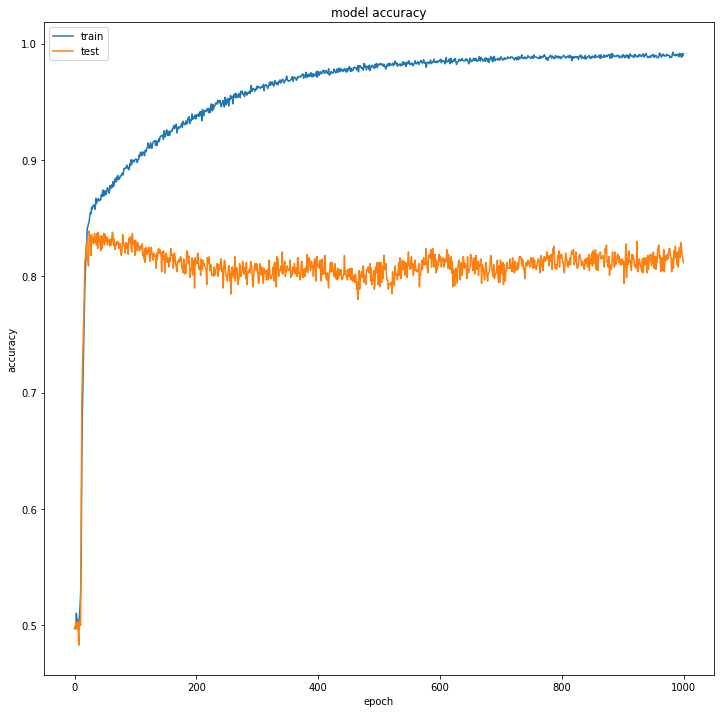

In [ ]:
#Lets plot the increase of accuracy as we increase the number of training epochs
#We can see that without any training the acc is about 50%, random guessing
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(12,12))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()